# Kd Trees

A Kd-tree, or K-dimensional tree, is a generalization of a binary search tree that stores points in a k-dimensional space. In computer science it is often used for organizing some number of points in a space with k dimensions. Kd-trees are very useful for range and nearest neighbor (NN) searches, it is a very common operation in computer vision, computational geometry, data mining, machine learning, DNA sequencing. 

The following code uses a 2-dimensional example.

Here is the basic `Node` definition:

In [2]:
from collections import namedtuple
from pprint import pformat

class Node(namedtuple('Node', 'location left_child right_child')):
    def __repr__(self):
        return pformat(tuple(self))

## Creating a Kd tree


Kd trees are defined by creating the respective `Node` objects. Trees should be balanced, which we can
achieve by sorting and using the median as a pivot:

In [3]:
from operator import itemgetter

def kdtree(point_list, depth=0):
    if len(point_list) == 0:
        return None
    
    # Select axis based on depth so that axis cycles through all valid values
    # (this is only 2-dim)
    axis = depth % 2

    # Sort point list and choose median as pivot element
    point_list.sort(key=itemgetter(axis))
    median = len(point_list) // 2  # choose median
    
    # Create node and construct subtrees
    return Node(
        location = point_list[median],
        left_child = kdtree(point_list[:median], depth + 1),
        right_child = kdtree(point_list[median + 1:], depth + 1)
    )

## Displaying a Kd tree

In order to visualize the algorithms we add a diagram type that shows how to partition the tree

In [4]:
import matplotlib.pyplot as plt

# line width for visualization of K-D tree
line_width = [4., 3.5, 3., 2.5, 2., 1.5, 1., .5, 0.3]


def plot_tree(tree, min_x, max_x, min_y, max_y, prev_node, branch, depth=0):
    """ plot K-D tree
    :param tree      input tree to be plotted
    :param min_x
    :param max_x
    :param min_y
    :param max_y
    :param prev_node parent's node
    :param branch    True if left, False if right
    :param depth     tree's depth
    :return tree     node
    """

    cur_node = tree.location  # current tree's node
    left_branch = tree.left_child  # its left branch
    right_branch = tree.right_child  # its right branch

    # set line's width depending on tree's depth
    if depth > len(line_width) - 1:
        ln_width = line_width[len(line_width) - 1]
    else:
        ln_width = line_width[depth]

    k = len(cur_node)
    axis = depth % k

    # draw a vertical splitting line
    if axis == 0:
        if branch is not None and prev_node is not None:
            if branch:
                max_y = prev_node[1]
            else:
                min_y = prev_node[1]

        plt.plot([cur_node[0], cur_node[0]], [min_y, max_y], 
                 linestyle='-', color='red', linewidth=ln_width)

    # draw a horizontal splitting line
    elif axis == 1:
        if branch is not None and prev_node is not None:
            if branch:
                max_x = prev_node[0]
            else:
                min_x = prev_node[0]

        plt.plot([min_x, max_x], [cur_node[1], cur_node[1]], 
                 linestyle='-', color='blue', linewidth=ln_width)

    # draw the current node
    plt.plot(cur_node[0], cur_node[1], 'ko')

    # draw left and right branches of the current node
    if left_branch is not None:
        plot_tree(left_branch, min_x, max_x, min_y, max_y, cur_node, True, depth + 1)

    if right_branch is not None:
        plot_tree(right_branch, min_x, max_x, min_y, max_y, cur_node, False, depth + 1)


This creates a diagram with axis and title into which we draw the kd-tree:

In [5]:
def create_diagram (tree, width, height, min_val, max_val, delta):
    plt.figure("K-d Tree", figsize=(width, height))
    plt.axis([min_val - delta, max_val + delta, min_val - delta, max_val + delta])

    plt.grid(b=True, which='major', color='0.75', linestyle='--')
    plt.xticks([i for i in range(min_val - delta, max_val + delta, 1)])
    plt.yticks([i for i in range(min_val - delta, max_val + delta, 1)])

    # draw the tree
    plot_tree(tree, min_val-delta, max_val+delta, min_val-delta, max_val+delta, None, None)
    plt.title('K-D Tree')

This labels the tree points in order of insertion (depth first)

In [6]:
def label_nodes (node, i):
    loc = node.location
    
    plt.text(loc[0]+0.15, loc[1]+0.15, str(i), fontsize=10)
    
    if node.left_child:
        i = label_nodes(node.left_child, i+1)
        
    if node.right_child:
        i = label_nodes(node.right_child, i+1)
        
    return i

The next two functions draw the input and output points for our queries

In [7]:
def draw_target(point,radius):
    plt.plot(point[0], point[1], marker='o', color='#ff007f')
    circle = plt.Circle(point, 0.3, facecolor='#ff007f', edgecolor='#ff007f', alpha=0.5)
    plt.gca().add_patch(circle)

    # draw the hypersphere around the target point
    circle = plt.Circle(point, radius, facecolor='#ffd83d', edgecolor='#ffd83d', alpha=0.5)
    plt.gca().add_patch(circle)

In [8]:
def draw_neighbors(point_list):
    for point in point_list:
        # draw the found nearest neighbor
        plt.plot(point[0], point[1], 'go')
        circle = plt.Circle(point, 0.3, facecolor='#33cc00', edgecolor='#33cc00', alpha=0.5)
        plt.gca().add_patch(circle)



The last visualization function displays the tree as a graph

In [9]:
from graphviz import Digraph

def add_node (dot, node, parent_id=None, i=0, edge_label=''):
    loc = node.location
    node_id = str(i)
    dot.node(node_id, f"{i}\n({loc[0]},{loc[1]})")
    if parent_id:
        dot.edge(parent_id, node_id, label=edge_label)    
    if node.left_child:
        i = add_node(dot, node.left_child, node_id, i+1, 'l')
    if node.right_child:
        i = add_node(dot, node.right_child, node_id, i+1, 'r')
    return i
        
def create_graph(tree):
    dot = Digraph(comment='Kd-tree')
    dot.attr('node', fontsize='10', shape='circle', width='0.5', fixedsize='true')
    dot.attr('edge', arrowsize='0.7')
    add_node(dot, tree)
    return dot

## Kd tree example

To show the above functions, we add support to generate (random) test data. First some useful constants

In [10]:
import sys

max_int = sys.maxsize
min_int = -max_int - 1
max_float = float('inf')

In [11]:
import random
import numpy as np

def generate_target (val_range):
    """compute so that it does not fall on a tree point"""
    return (np.random.normal(random.randint(val_range[0],val_range[1]), scale=0.5), 
            np.random.normal(random.randint(val_range[0],val_range[1]), scale=0.5))


def generate_point(val_range):
    return (random.randint(val_range[0],val_range[1]),
            random.randint(val_range[0],val_range[1]))

def generate_point_list(n, val_range):
    points = []

    for i in range(n):
        # for the sake of visualization, don't add duplicates
        while True:
            p = generate_point(val_range)
            if p not in points:
                points.append(p)
                break
    return points

In [12]:
def get_val_range(point_list):
    min_val = max_int
    max_val = min_int
    for point in point_list:
        min_v = min(point)
        if min_v < min_val:
            min_val = min_v
        max_v = max(point)
        if max_v > max_val:
            max_val = max_v
    return (min_val, max_val)

Now we are ready to show the Kd-trees in action. We start with fixed input.

((7, 2),
 ((5, 4), ((2, 3), None, None), ((4, 7), None, None)),
 ((9, 6), ((8, 1), None, None), None))


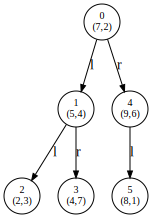

In [13]:
point_list = [(2,3), (5,4), (9,6), (4,7), (8,1), (7,2)]
tree = kdtree(point_list)
min_val, max_val = get_val_range(point_list)
print(tree)
create_graph(tree)

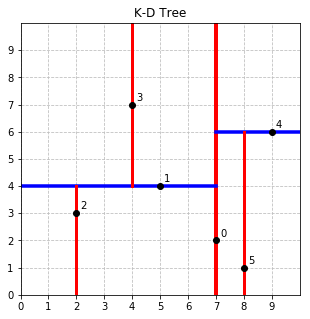

In [14]:
create_diagram(tree, 5., 5., min_val, max_val, 1)
label_nodes(tree, 0)
plt.show()

To see how this scales up, play with the parameter widgets below

In [15]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def plot_example(n, min_val, max_val):
    tree = kdtree(generate_point_list(n, (min_val, max_val)))
    create_diagram(tree, 8., 8., min_val, max_val, 1)
    
interact(plot_example, 
         n=widgets.IntSlider(min=5,max=50,step=1,value=10),
         min_val=0, max_val=10)

plt.show()

interactive(children=(IntSlider(value=10, description='n', max=50, min=5), IntSlider(value=0, description='min…

## Nearest Neighbor search

First, we need some auxiliary infrastructure. We start with a class that provides an interface which will generalize the types of queries we can do:

 - what is the nearest neighbor in the tree for a given target location
 - which are the N nearest neighbors for a given target
 - what are all the neighbors within distance R of a given target
    
This also abstracts the nature of location coordinates by providing `distance()` functions, which do not have to be cartesian 

In [16]:
import math

class NearestNeighborResult:
    def __init__(self):
        self.distance = float('inf')
        self.location = None

    def can_contain(self, rel_dist):
        return rel_dist < self.distance  
        
    def update(self, dist, loc):
        if dist < self.distance:
            self.distance = dist
            self.location = loc
        return self

    def compute_rel_distance(self, loc_a, loc_b):
        return (loc_a[0] - loc_b[0])**2 + (loc_a[1] - loc_b[1])**2
    
    def get_abs_distance(self):
        return math.sqrt(self.distance)

Second, we need a helper to compute the (hypothetical) nearest point in a sub-tree (hyperplane): 

In [17]:
def compute_closest_coordinate(value, range_min, range_max):
    if value <= range_min:      #  X  <------->
        return range_min        #     ^
    elif value >= range_max:    #  <-------->  X
        return range_max        #           ^
    else:                       #    <------X--->
        return value            #           ^
    
def compute_closest_point(location, hr):
    return (compute_closest_coordinate( location[0], hr[0][0], hr[1][0]),
            compute_closest_coordinate( location[1], hr[1][1], hr[0][1]))

The next helper is used to split a bounding region (*hyperplane*) based on a given test point and axis.

In [18]:
def split_hyperplane (point, hr, axis):
    if axis == 0:
        left_hr = [hr[0], (point[0], hr[1][1])]
        right_hr = [(point[0], hr[0][1]), hr[1]]
        
    elif axis == 1:
        left_hr = [(hr[0][0], point[1]), hr[1]]
        right_hr = [hr[0], (hr[1][0], point[1])]
        
    return left_hr, right_hr

We also need some global constants and variables:

In [19]:
import sys

maxint = sys.maxsize
minint = -maxint - 1
hr_max = [(minint, maxint), (maxint, minint)]
dist_max = float('inf')

search_steps = 0   # just some call statistics to see how good the algorithm works

Now we can formulate the nearest neighbor search algorithm. It goes like this:

  1. Starting with the root node, the algorithm moves down the tree recursively (it goes left or right depending on whether the point is less than or greater than the current node in the split dimension).
  2. Traversing the tree the algorithm saves the node featured by the shortest distance to the target point as the “current best”.
  3. Once the algorithm reaches a leaf node, it unwinds the recursion of the tree performing the following steps at each node:
     a. If the current node is closer than the current best, then it becomes the current best.
     b. The algorithm checks whether there could be any points on the other side of the splitting plane that are closer to the target point than the current best. This is done by intersecting the splitting hyperplane with a hypersphere around the target point. The sphere has a radius equal to the current nearest distance. Since the hyperplanes are all axis-aligned, this is implemented as a simple comparison to see whether the difference between the splitting coordinate of the target point and the current node is less than the distance from the target point to the current best. For this we will use so-called *hyper-rectangles*: every hyperplane divides the current hyperrectangle into two pieces: “near hyperrectangle” where the target point belongs to and “further hyperrectangle” on the other side of the hyperplane.
        - If the hypersphere crosses the plane, there could be nearer points on the other side of the plane. It means the algorithm must move down the other branch of the tree from the current node looking for closer points, following the same recursive process as the entire search.
        - If the hypersphere doesn’t intersect the splitting plane, then the algorithm continues walking up the tree, and the entire branch on the other side of that node is eliminated.
  4. The search is complete when the algorithm finishes this procedure for the root node

In [20]:
def search_kdtree(tree, target_point, result, hr=hr_max, depth=0):
    global search_steps
    if depth == 0:
        search_steps = 1
    else:
        search_steps += 1

    cur_node = tree.location
    left_branch = tree.left_child
    right_branch = tree.right_child

    nearer_kd = farther_kd = None
    nearer_hr = farther_hr = None

    # Select axis based on depth so that axis cycles through all valid values
    # (we only use 2 dim here)
    axis = depth % 2

    # split the hyperplane depending on the axis
    left_hr, right_hr = split_hyperplane(cur_node, hr, axis)

    # check which hyperplane the target point belongs to
    if target_point[axis] <= cur_node[axis]:
        nearer_kd = left_branch
        farther_kd = right_branch
        nearer_hr = left_hr
        farther_hr = right_hr
    else:
        nearer_kd = right_branch
        farther_kd = left_branch
        nearer_hr = right_hr
        farther_hr = left_hr

    # check whether the current node is closer
    dist = result.compute_rel_distance(cur_node, target_point)
    new_result = result.update(dist, cur_node)
    
    # first, go deeper in the tree along the nearer_kd branch
    if nearer_kd:
        search_kdtree(nearer_kd, target_point, new_result, nearer_hr, depth+1)

    # there still could be a nearer point (px,py) in the farther_kd, 
    #   compute the possibly closest point in that region
    if farther_kd:
        pt = compute_closest_point(target_point, farther_hr)

        # check if this hypothetical point would be closer than the current nearest neighbor
        dist = new_result.compute_rel_distance( pt, target_point)
        if new_result.can_contain(dist):
            new_result = search_kdtree(farther_kd, target_point, new_result, farther_hr, depth+1)
            
    return new_result

Let's put this to test. Run the next cell a couple of times to verify the results.

In [21]:
def create_and_plot_tree(n, val_range):
    point_list = generate_point_list(n, val_range)
    tree = kdtree(point_list)
    create_diagram(tree, 8., 8., val_range[0], val_range[1], 1)
    return tree

def mark_nodes(target, dist, nodes):
    draw_target(point, dist)
    draw_neighbors(nodes)

number of nodes: 50
number of search steps: 6


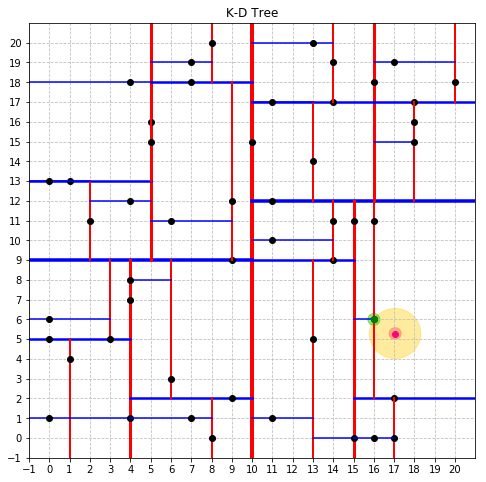

In [22]:
n = 50
val_range = (0, 20)
tree = create_and_plot_tree( n, val_range)
point = generate_target(val_range)

result = search_kdtree(tree, point, NearestNeighborResult())
print(f"number of nodes: {n}")
print(f"number of search steps: {search_steps}")

mark_nodes(point, result.get_abs_distance(), [result.location])
plt.show()

Finding the NN is a $O(\log n)$ operation in case of randomly distributed points. The biggest advantage of the NN search using Kd-trees is that it allows us to eliminate many points from consideration and focus only on some tree’s branches. However, in high-dimensional spaces, the curse of dimensionality causes the algorithm to visit many more branches than in lower-dimensional spaces. In particular, when the number of points is only slightly higher than the number of dimensions, the algorithm is only slightly better than a linear search of all points.

## N nearest neighbors

Extending this algorithm to find the N nearest neightbors is straight forward - we just have to replace the `result` argument with a type that implements a sorted list with an upper size bound

In [23]:
from sortedcontainers import SortedList

class NNeighborsResult:
    def __init__(self, n):
        self.n = n
        self.list = SortedList(None,key=itemgetter(0))
        self.dist_max = float('inf')
        
    def size(self):
        return len(self.list)
        
    def can_contain(self, rel_dist):
        return rel_dist < self.dist_max  
        
    def update(self, dist, loc):
        if len(self.list) < self.n:  # not full yet
            self.list.add((dist, loc))
            if dist > self.dist_max:
                self.dist_max = dist
                
        elif dist < self.dist_max:   # full, check dist_max
            self.list.add((dist, loc))
            self.list.pop(self.n)
            self.dist_max = self.list[self.n-1][0]
            
        return self

    def compute_rel_distance(self, loc_a, loc_b):
        return (loc_a[0] - loc_b[0])**2 + (loc_a[1] - loc_b[1])**2
    
    def get_abs_distance(self):
        return math.sqrt(self.dist_max)

number of nodes: 50
number of neighbors: 5
number of search steps: 24


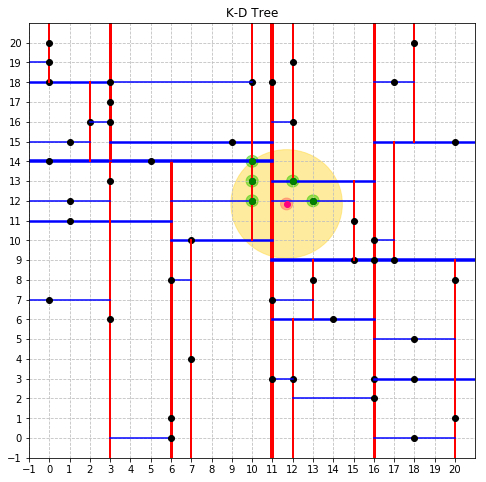

In [24]:
n = 50
val_range = (0, 20)
tree = create_and_plot_tree( n, val_range)
point = generate_target(val_range)

result = search_kdtree(tree, point, NNeighborsResult(5))
print(f"number of nodes: {n}")
print(f"number of neighbors: {result.size()}")
print(f"number of search steps: {search_steps}")

mark_nodes(point, result.get_abs_distance(), map(lambda r: r[1], result.list))
plt.show()

## Range Query

To find all nodes which are within a given distance of the target point we can use the following result type

In [25]:
class RangeNeighborsResult:
    def __init__(self, abs_dist):
        self.list = SortedList(None,key=itemgetter(0))
        self.dist_max = abs_dist**2
        
    def size(self):
        return len(self.list)
        
    def can_contain(self, rel_dist):
        return rel_dist < self.dist_max  
        
    def update(self, dist, loc):
        if dist < self.dist_max:
            self.list.add((dist, loc))
        return self

    def compute_rel_distance(self, loc_a, loc_b):
        return (loc_a[0] - loc_b[0])**2 + (loc_a[1] - loc_b[1])**2
    
    def get_abs_distance(self):
        return math.sqrt(self.dist_max)

number of nodes: 50
number of neighbors in range <= 6: 7
number of search steps: 20


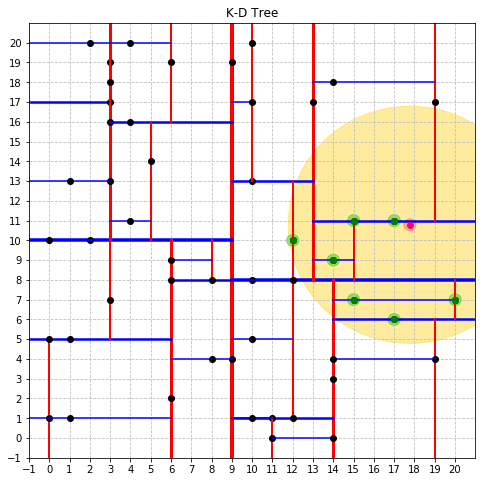

In [26]:
n = 50
val_range = (0, 20)
max_distance = 6
tree = create_and_plot_tree( n, val_range)
point = generate_target(val_range)

result = search_kdtree(tree, point, RangeNeighborsResult(max_distance))
print(f"number of nodes: {n}")
print(f"number of neighbors in range <= {max_distance}: {result.size()}")
print(f"number of search steps: {search_steps}")

mark_nodes(point, result.get_abs_distance(), map(lambda r: r[1], result.list))
plt.show()